# Лабораторная работа №11 “Реализация криптографических атак с помощью машинного обучения на физически неклонируемые функции”

### *Физически неклонируемые функции (ФНФ) часто используются в качестве криптографических примитивов при реализации протоколов аутентификации.*
### *В данном случае устройство А, содержащее реализацию ФНФ, может быть аутентифицировано с помощью набора запросов (challenge) и проверки ответов на них (response). При этом использованные пары запрос-ответ удаляются из базы данных устройства.*
### Более подробно о физически неклонируемых функциях можно прочесть:
### - https://habr.com/post/343386/
### - https://www.researchgate.net/profile/Alexander_Ivaniuk/publication/322077869_Proektirovanie_vstraivaemyh_cifrovyh_ustrojstv_i_sistem/links/5a43724caca272d2945a0464/Proektirovanie-vstraivaemyh-cifrovyh-ustrojstv-i-sistem.pdf (глава 5, раздел 4)


## **Задание**

### 1. Изучите классическую работу У. Рурмаира о криптографических атаках с помощью машинного обучения на ФНФ. U. Ruhrmair et al., “Modeling attacks on physical unclonable functions,” in Proc. ACM Conf. on Comp. and Comm. Secur. (CCS’10), Oct. 2010, pp. 237–249. https://eprint.iacr.org/2010/251.pdf

### 2. Сформулируйте задачу в терминах машинного обучения.

PUF - это некий уникальный физический процесс, для каждого объекта(везде рассматриваются интегральные схемы) он чуть-чуть разный, но его нельзя точно воспроизвести на другом устройстве. Есть challenges, это некие входные параметры в эту функцию PUF и она выдает responses. Будем считать challenges за X, а responses за Y и пытаться научиться предсказывать Y по X.

### 3. Обучите модель, которая могла бы предсказывать ответы по запросам, которых нет в обучающей выборке.

In [16]:
import os
import sys

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

%matplotlib inline

sys.path.insert(0, 'pypuf/')

os.environ["OMP_NUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'

In [3]:
from pypuf import tools
from pypuf.simulation.arbiter_based.ltfarray import LTFArray

instance = LTFArray(
    weight_array=LTFArray.normal_weights(n=64, k=2),
    transform=LTFArray.transform_atf,
    combiner=LTFArray.combiner_xor
)

train_set = tools.TrainingSet(instance=instance, N=15000)
val_set = train_set.subset(slice(10000, None))
train_set = train_set.subset(slice(None, 10000))

challenges, responses = train_set.challenges, train_set.responses

print(challenges.shape, responses.shape)

(10000, 64) (10000,)


In [4]:
from pypuf.learner.regression.logistic_regression import LogisticRegression

lr_learner = LogisticRegression(
    t_set=train_set,
    n=64,
    k=2,
    transformation=LTFArray.transform_atf,
    combiner=LTFArray.combiner_xor,
)

model = lr_learner.learn()

In [10]:
val_set_predicted_responses = model.eval(val_set.challenges)
acc = accuracy_score(val_set_predicted_responses, val_set.responses)

print('accuracy: ', acc)

accuracy:  0.9932


### 4. Применить как минимум 3 различных алгоритма (например, метод опорных векторов, логистическая регрессия и градиентный бустинг).

In [31]:
from pypuf.learner.other import Boosting

boosting_learner = Boosting(
    t_set=train_set,
    n=64,
    k=1,
    transformation=LTFArray.transform_atf,
    combiner=LTFArray.combiner_xor,
)

model_boosting = boosting_learner.learn()

val_set_predicted_responses = model_boosting.eval(val_set.challenges)

acc = round(accuracy_score(val_set_predicted_responses, val_set.responses), 4)

print('accuracy for gradient boosting: ', acc)

accuracy for gradient boosting:  0.51


In [28]:
from pypuf.learner.other import SVM

svm_learner = SVM(
    t_set=train_set,
    n=64,
    k=1,
    transformation=LTFArray.transform_atf,
    combiner=LTFArray.combiner_xor,
)

model_svm = svm_learner.learn()

val_set_predicted_responses = model_svm.eval(val_set.challenges)

acc = round(accuracy_score(val_set_predicted_responses, val_set.responses), 4)

print('accuracy for SVM: ', acc)

accuracy for SVM:  0.5082


In [26]:
from pypuf.learner.regression.logistic_regression import LogisticRegression

lr_learner = LogisticRegression(
    t_set=train_set,
    n=64,
    k=2,
    transformation=LTFArray.transform_atf,
    combiner=LTFArray.combiner_xor,
)

model = lr_learner.learn()

val_set_predicted_responses = model.eval(val_set.challenges)

acc = accuracy_score(val_set_predicted_responses, val_set.responses)

print('accuracy for logistic regression: ', acc)

accuracy for logistic regression:  0.9932


### 5. Какая метрика наиболее подходит для оценки качества алгоритма?

Поскольку это используется для идентификации объектов, то можно взять любую метрику оттуда:

TAR@FAR=10^n, Rank-k@10^n и т.д.

### 6. Какой наибольшей доли правильных ответов (Accuracy) удалось достичь?

0.99

### 7. Какой размер обучающей выборки необходим, чтобы достигнуть доли правильных ответов минимум 0.95?
### 8. Как зависит доля правильных ответов от N?
### 9. Ответы на вопросы представьте в виде графиков.

Для того, чтобы обучить c качеством выше 0.95, достаточно уже порядка 2000 примеров для данного псевдослучайного набора CRPs(Challenge-Response pairs). С увеличением числа примеров количество правильных ответов растет.
График ниже.

In [14]:
def pipeline(N):
    instance = LTFArray(
        weight_array=LTFArray.normal_weights(n=64, k=2),
        transform=LTFArray.transform_atf,
        combiner=LTFArray.combiner_xor
    )

    train_set = tools.TrainingSet(instance=instance, N=N)

    train_size = int(len(train_set.challenges) * 0.95)

    val_set = train_set.subset(slice(train_size, None))
    train_set = train_set.subset(slice(None, train_size))
    
    lr_learner = LogisticRegression(
        t_set=train_set,
        n=64,
        k=2,
        transformation=LTFArray.transform_atf,
        combiner=LTFArray.combiner_xor,
    )

    model = lr_learner.learn()
    
    val_set_predicted_responses = model.eval(val_set.challenges)

    accuracy = accuracy_score(val_set_predicted_responses, val_set.responses)
    
    return accuracy

In [22]:
N2accuracy = [(N, pipeline(N)) for N in [10, 50, 100, 500, 1000, 1500, 2000, 3000, 5000]]  

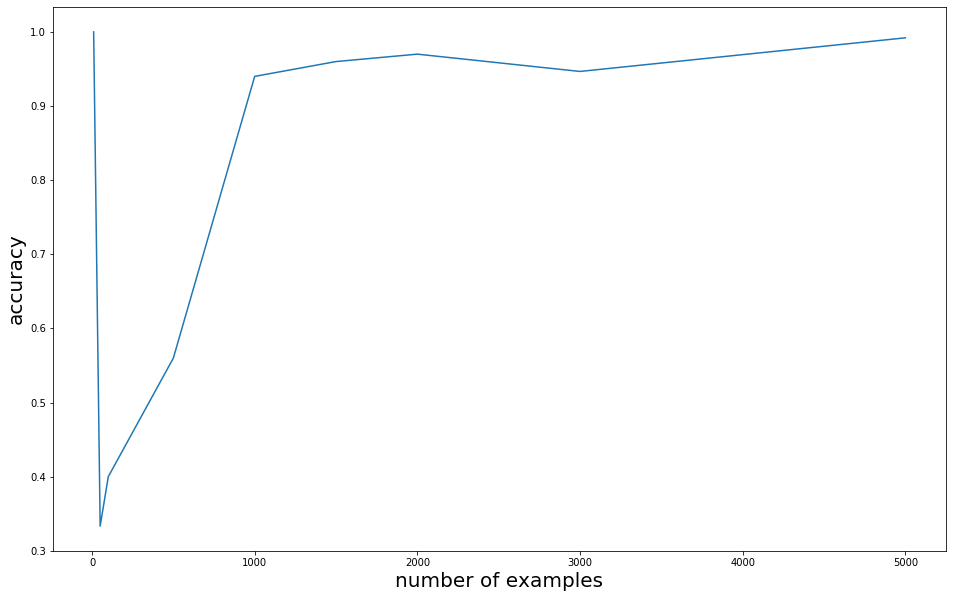

In [24]:
plt.figure(figsize=(16,10))
plt.plot(*zip(*N2accuracy))

plt.xlabel('number of examples', size=20)
plt.ylabel('accuracy', size=20)
plt.show()